# CMIP6 SSP Prediction

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import pickle

In [2]:
# Add the folder to the Python path

os.chdir("../")
# change working directory to project's root path
print(os.getcwd())

folder_path = os.path.abspath("functions/") #INPUT_PATH)#'path_to_your_folder')  # Replace with the actual folder path
sys.path.insert(0, folder_path)

c:\Users\marti\Desktop\data\hw_extra


## Load cmip6 drivers

In [3]:
import tensorflow as tf
import os
import numpy as np
import random
import keras
SEED = 42

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    keras.utils.set_random_seed(seed)

def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(seed=SEED)
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout, GRU, Conv1D, Flatten, Reshape

In [4]:
from Predictions import (
    PredictionModel,
    SERA,
)

c:\Users\marti\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Load Data

In [29]:
path_drivers_ssp = "data/03_primary/drivers/dfs_dict_ssps.pickle"
with open(path_drivers_ssp, 'rb') as handle:
    cmip6_drivers_dfs = pickle.load(handle)

scenarios = list(cmip6_drivers_dfs["EC-Earth3"].keys())
cmip6_models = list(cmip6_drivers_dfs.keys())
print("Scenarios", scenarios)
print("Models", cmip6_models)

Scenarios ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']
Models ['MPI-ESM1-2-HR', 'MRI-ESM2-0', 'GFDL-ESM4', 'EC-Earth3', 'MIROC6', 'AWI-CM-1-1-MR', 'INM-CM4-8']


In [30]:
path_ensemble = "data/03_primary/drivers/df_ensemble_ssps.pickle"
with open(path_ensemble, 'rb') as handle:
    ensemble_scenario = pickle.load(handle)

In [31]:
cmip6_drivers_dfs["ensemble_mean"] = ensemble_scenario

In [32]:
path_drivers_historical = "data/03_primary/drivers/dfs_dict.pickle"
with open(path_drivers_historical, 'rb') as handle:
    historical_dfs = pickle.load(handle)

In [33]:
hws_chile = pd.read_csv("data/local_data/monthly/hws_chile_library.csv")

hws_chile["time"] = pd.to_datetime(hws_chile["Unnamed: 0"],format='%Y-%m')
hws_chile.set_index('time', inplace=True)
hws_chile.drop(columns="Unnamed: 0", inplace=True)
hws_chile

hwn  hwf  hwd       hwm       hwa
time                                         
1971-01-01  0.0  0.0  0.0  0.000000  0.000000
1971-02-01  0.2  0.7  0.7  0.447148  0.807169
1971-03-01  0.0  0.0  0.0  0.000000  0.000000
1971-04-01  0.2  0.6  0.6  0.637038  0.982249
1971-05-01  0.1  0.3  0.3  0.555671  0.901254
...         ...  ...  ...       ...       ...
2023-08-01  0.3  1.0  1.0  0.902918  1.456688
2023-09-01  0.0  0.0  0.0  0.000000  0.000000
2023-10-01  0.1  0.3  0.3  0.062737  0.077569
2023-11-01  0.0  0.0  0.0  0.000000  0.000000
2023-12-01  0.1  0.6  0.6  0.077252  0.163605

[636 rows x 5 columns]

In [34]:
era5_df = pd.concat((historical_dfs["ERA5"],hws_chile),axis=1)
era5_df

nino12    nino34  anom_wind_cl_raco  anom_wind_cl_puelche   
time                                                                      
1971-01-01 -1.928113 -1.640253           0.006237              1.624297  \
1971-02-01 -2.979414 -1.713375          -0.288501              0.221068   
1971-03-01 -3.288180 -2.059431          -0.232439              0.302271   
1971-04-01 -2.543985 -2.459558          -0.485039             -0.753484   
1971-05-01 -1.714362 -2.507134          -0.089548              0.699281   
...              ...       ...                ...                   ...   
2023-08-01  2.723302  1.550383           1.282423              1.932909   
2023-09-01  2.123090  1.722627           0.850378              1.987928   
2023-10-01  1.840521  1.741871          -0.057451             -0.161683   
2023-11-01  1.625754  1.960339           0.096582              1.173807   
2023-12-01  1.109014  2.099410          -0.348814             -1.820655   

            anom_wind_pressure  anom_ta_cl  anom_pdo  anom_psl_sam_40   
time                                                                    
1971-01-01         -155.360306    1.249381  0.997573      -112.387703  \
1971-02-01          -98.484497   -0.026722  0.767220        57.690361   
1971-03-01          -77.386848   -0.150289  0.633572         6.743707   
1971-04-01          198.601791   -0.788936  0.562198       -70.511070   
1971-05-01          185.134171    0.501217  0.420079      -178.369583   
...                        ...         ...       ...              ...   
2023-08-01         -374.929413    2.065721  1.704082       -33.429050   
2023-09-01         -178.303970    1.922226  2.295783        29.182522   
2023-10-01           24.046869   -0.402164  2.689852       312.206818   
2023-11-01         -339.330139    0.945060  2.757317       124.789513   
2023-12-01          303.737122   -1.503564  2.452650       269.578552   

            anom_psl_sam_65  anom_dmi_east  ...  longitude       pressure   
time                                        ...                             
1971-01-01       341.377930       0.051705  ...     255.00  102347.242188  \
1971-02-01        51.769032      -0.038294  ...     255.00  102348.992188   
1971-03-01      -146.034164      -0.249040  ...     269.00  102237.007812   
1971-04-01       233.869843      -0.472573  ...     271.75  102222.132812   
1971-05-01       701.905396      -0.592277  ...     293.00  102046.421875   
...                     ...            ...  ...        ...            ...   
2023-08-01       154.142227       0.257379  ...     293.00  102131.015625   
2023-09-01       252.867569       0.023470  ...     255.00  102677.593750   
2023-10-01      -144.109970      -0.294358  ...     255.00  102781.796875   
2023-11-01        80.167175      -0.467022  ...     255.00  102752.578125   
2023-12-01      -609.298462      -0.471782  ...     260.50  102704.679688   

            high_low_difference  adv_blob  adv_chile  hwn  hwf  hwd       hwm   
time                                                                            
1971-01-01           -67.718750 -1.075192   5.139239  0.0  0.0  0.0  0.000000  \
1971-02-01            36.468750  0.878110   0.437056  0.2  0.7  0.7  0.447148   
1971-03-01            64.906250 -3.049048  -0.064510  0.0  0.0  0.0  0.000000   
1971-04-01           191.304688  0.137372  -0.576733  0.2  0.6  0.6  0.637038   
1971-05-01            49.265625  0.105984  -0.972252  0.1  0.3  0.3  0.555671   
...                         ...       ...        ...  ...  ...  ...       ...   
2023-08-01           -88.976562 -2.776886  -0.530017  0.3  1.0  1.0  0.902918   
2023-09-01           -98.132812 -0.182294   3.426786  0.0  0.0  0.0  0.000000   
2023-10-01           -85.257812 -1.519804  -1.120164  0.1  0.3  0.3  0.062737   
2023-11-01          -210.367188  1.716634   1.758876  0.0  0.0  0.0  0.000000   
2023-12-01           -60.773438 -0.719822  -0.454558  0.1  0.6  0.6  0.077252   

                 hwa  
time     

## Predict by season

In [36]:
indices_of_interest = list(hws_chile.columns)
bounds = (-1.1692892810242344, -0.30647585455315646, 3.0, 6.499969486244418)
loss_fn=SERA(bounds=bounds,T=100, initial_weight=0.1, fn="piecewise2")
models_scenario_predicted = {model: {} for model in cmip6_drivers_dfs.keys()}
seasons_label_scalers = {}

for i in range(1,13):
    df_season = era5_df[era5_df.index.month==i]
    cnn_rnn_model = Sequential([
            Conv1D(16, kernel_size=1, activation="relu", input_shape=(1, len(era5_df.columns) - len(indices_of_interest))),
            Reshape((1, 16)),  # Back to time dimension
            SimpleRNN(8, activation="tanh"),
            Dropout(0.1),
            Dense(len(indices_of_interest))
        ])
    pred = PredictionModel(df_season, i, indices_of_interest, cnn_rnn_model, name_regressor="CNNRNN16",loss_fn=loss_fn)
    seasons_label_scalers[i] = pred.label_scaler
    pred.compile_keras_model()
    
    y_train, y_pred_train = pred.train(5)
    for name, scenarios_df in cmip6_drivers_dfs.items():
        for scenario in scenarios:
            if i==1:
                models_scenario_predicted[name][scenario] = pd.DataFrame()
            df_target = scenarios_df[scenario][scenarios_df[scenario].index.month==i]
            if scenario == "historical":
                df_target = df_target[(df_target.index.year >=1970) & (df_target.index.year <= 2014)]
            else:
                df_target = df_target[(df_target.index.year >=2015) & (df_target.index.year <= 2100)]
            # df_target[indices_of_interest] = df_season[indices_of_interest]
            # Normalize cmip6 features for machine input
            target = pred.scaler_X.transform(df_target[pred.scaler_X.feature_names_in_])
            # Reshape for keras and predict
            predicted_normalized = pred.regressor.predict(pred.reshape_for_keras(target))
            # Transform back to original range
            predicted_real = pred.label_scaler.inverse_transform(predicted_normalized)
            predicted = pd.DataFrame(predicted_real).rename(columns={i: label for i,label in enumerate(indices_of_interest)})
            predicted["Date"] = df_target.index
            predicted.set_index("Date",inplace=True)
            models_scenario_predicted[name][scenario] = pd.concat((models_scenario_predicted[name][scenario],predicted),axis=0)
        


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


3/3 [==============================] - 0s 2ms/step


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


3/3 [==============================] - 0s 2ms/step


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


3/3 [==============================] - 0s 1ms/step


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


3/3 [==============================] - 0s 2ms/step


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


3/3 [==============================] - 0s 2ms/step


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


3/3 [==============================] - 0s 1ms/step


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


3/3 [==============================] - 0s 2ms/step


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


3/3 [==============================] - 0s 2ms/step


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


3/3 [==============================] - 0s 2ms/step


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


3/3 [==============================] - 0s 2ms/step


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


3/3 [==============================] - 0s 2ms/step


c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.labels] = self.label_scaler.fit_transform(data[self.labels])
c:\Users\marti\Desktop\data\hw_extra\functions\Predictions.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features] = self.scaler_X.transform(data[features])


3/3 [==============================] - 0s 2ms/step


### Build Mean Prediction of all models

In [44]:
mean_scenario = {}
for scenario in scenarios:
    temp_df = pd.DataFrame()
    for name, model_scenario in models_scenario_predicted.items():
        temp_df = pd.concat((temp_df, model_scenario[scenario]), axis=1)
        
    mean_scenario[scenario] = pd.DataFrame(columns=models_scenario_predicted["EC-Earth3"][scenario].columns,index=model_scenario[scenario].index)
    for col in np.unique(temp_df.columns):
        mean_scenario[scenario][col] = temp_df[col].mean(axis=1)
models_scenario_predicted["mean"] = mean_scenario
models_scenario_predicted["mean"]

{'historical':                  hwn       hwf       hwd       hwm       hwa
 Date                                                        
 1970-01-01  0.226351  1.380201  1.330090  0.456432  0.494398
 1971-01-01  0.512526  1.938629  1.564163  0.941021  1.611445
 1972-01-01  0.429629  1.540867  1.463782  0.854334  1.264685
 1973-01-01  0.543602  1.858453  1.524966  0.986599  1.728053
 1974-01-01  0.453374  1.704399  1.373121  0.814497  1.335738
 ...              ...       ...       ...       ...       ...
 2010-12-01  0.046361  0.767614  0.161255  0.148544  0.211987
 2011-12-01  0.159034  0.974612  0.611064  0.205668  0.593268
 2012-12-01  0.370272  1.274868  0.942778  0.350170  0.878452
 2013-12-01  0.456647  1.440274  1.334910  0.486718  1.097396
 2014-12-01  0.147603  0.931504  0.519375  0.260638  0.430662
 
 [540 rows x 5 columns],
 'ssp126':                  hwn       hwf       hwd       hwm       hwa
 Date                                                        
 2015-01-01  0.6539

## Build yearly and decadal indices

In [ ]:
for scenario in scenarios:
    models_scenario_predicted["mean"][scenario] = models_scenario_predicted["mean"][scenario].astype(np.float64)

In [ ]:
models_predicted_yearly = {model: {} for model in models_scenario_predicted.keys()}
models_predicted_decadal = {model: {} for model in models_scenario_predicted.keys()}

for name, model_scenario in models_scenario_predicted.items():
    for scenario, df in model_scenario.items():
        df = df.sort_index()
        df["decade"] = (df.index.year // 10) * 10
        df["year"] = df.index.year

        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        for drop_col in ["time", "Date"]:
            if drop_col in numeric_cols:
                numeric_cols.remove(drop_col)

        # Base aggregation rules
        agg_dict = {}
        for col in numeric_cols:
            if col in ['hwn', 'hwf']:
                agg_dict[col] = 'sum'
            elif col in ['hwd', 'hwa']:
                agg_dict[col] = 'max'

        df_year_grouped = df.groupby('year')[numeric_cols].agg(agg_dict)
        df_decadal_grouped = df.groupby('decade')[numeric_cols].agg(agg_dict)

        # Custom aggregation for hwm (weighted mean)
        def weighted_mean(group):
            if group["hwf"].sum() == 0:
                return 0.0
            return (group["hwm"] * group["hwf"]).sum() / group["hwf"].sum()

        hwm_year = df.groupby("year").apply(weighted_mean)
        hwm_decade = df.groupby("decade").apply(weighted_mean)

        # Add hwm back
        df_year_grouped["hwm"] = hwm_year
        df_decadal_grouped["hwm"] = hwm_decade

        models_predicted_yearly[name][scenario] = df_year_grouped
        models_predicted_decadal[name][scenario] = df_decadal_grouped


## Heatwave Indices Visualization

### EC-Earth3

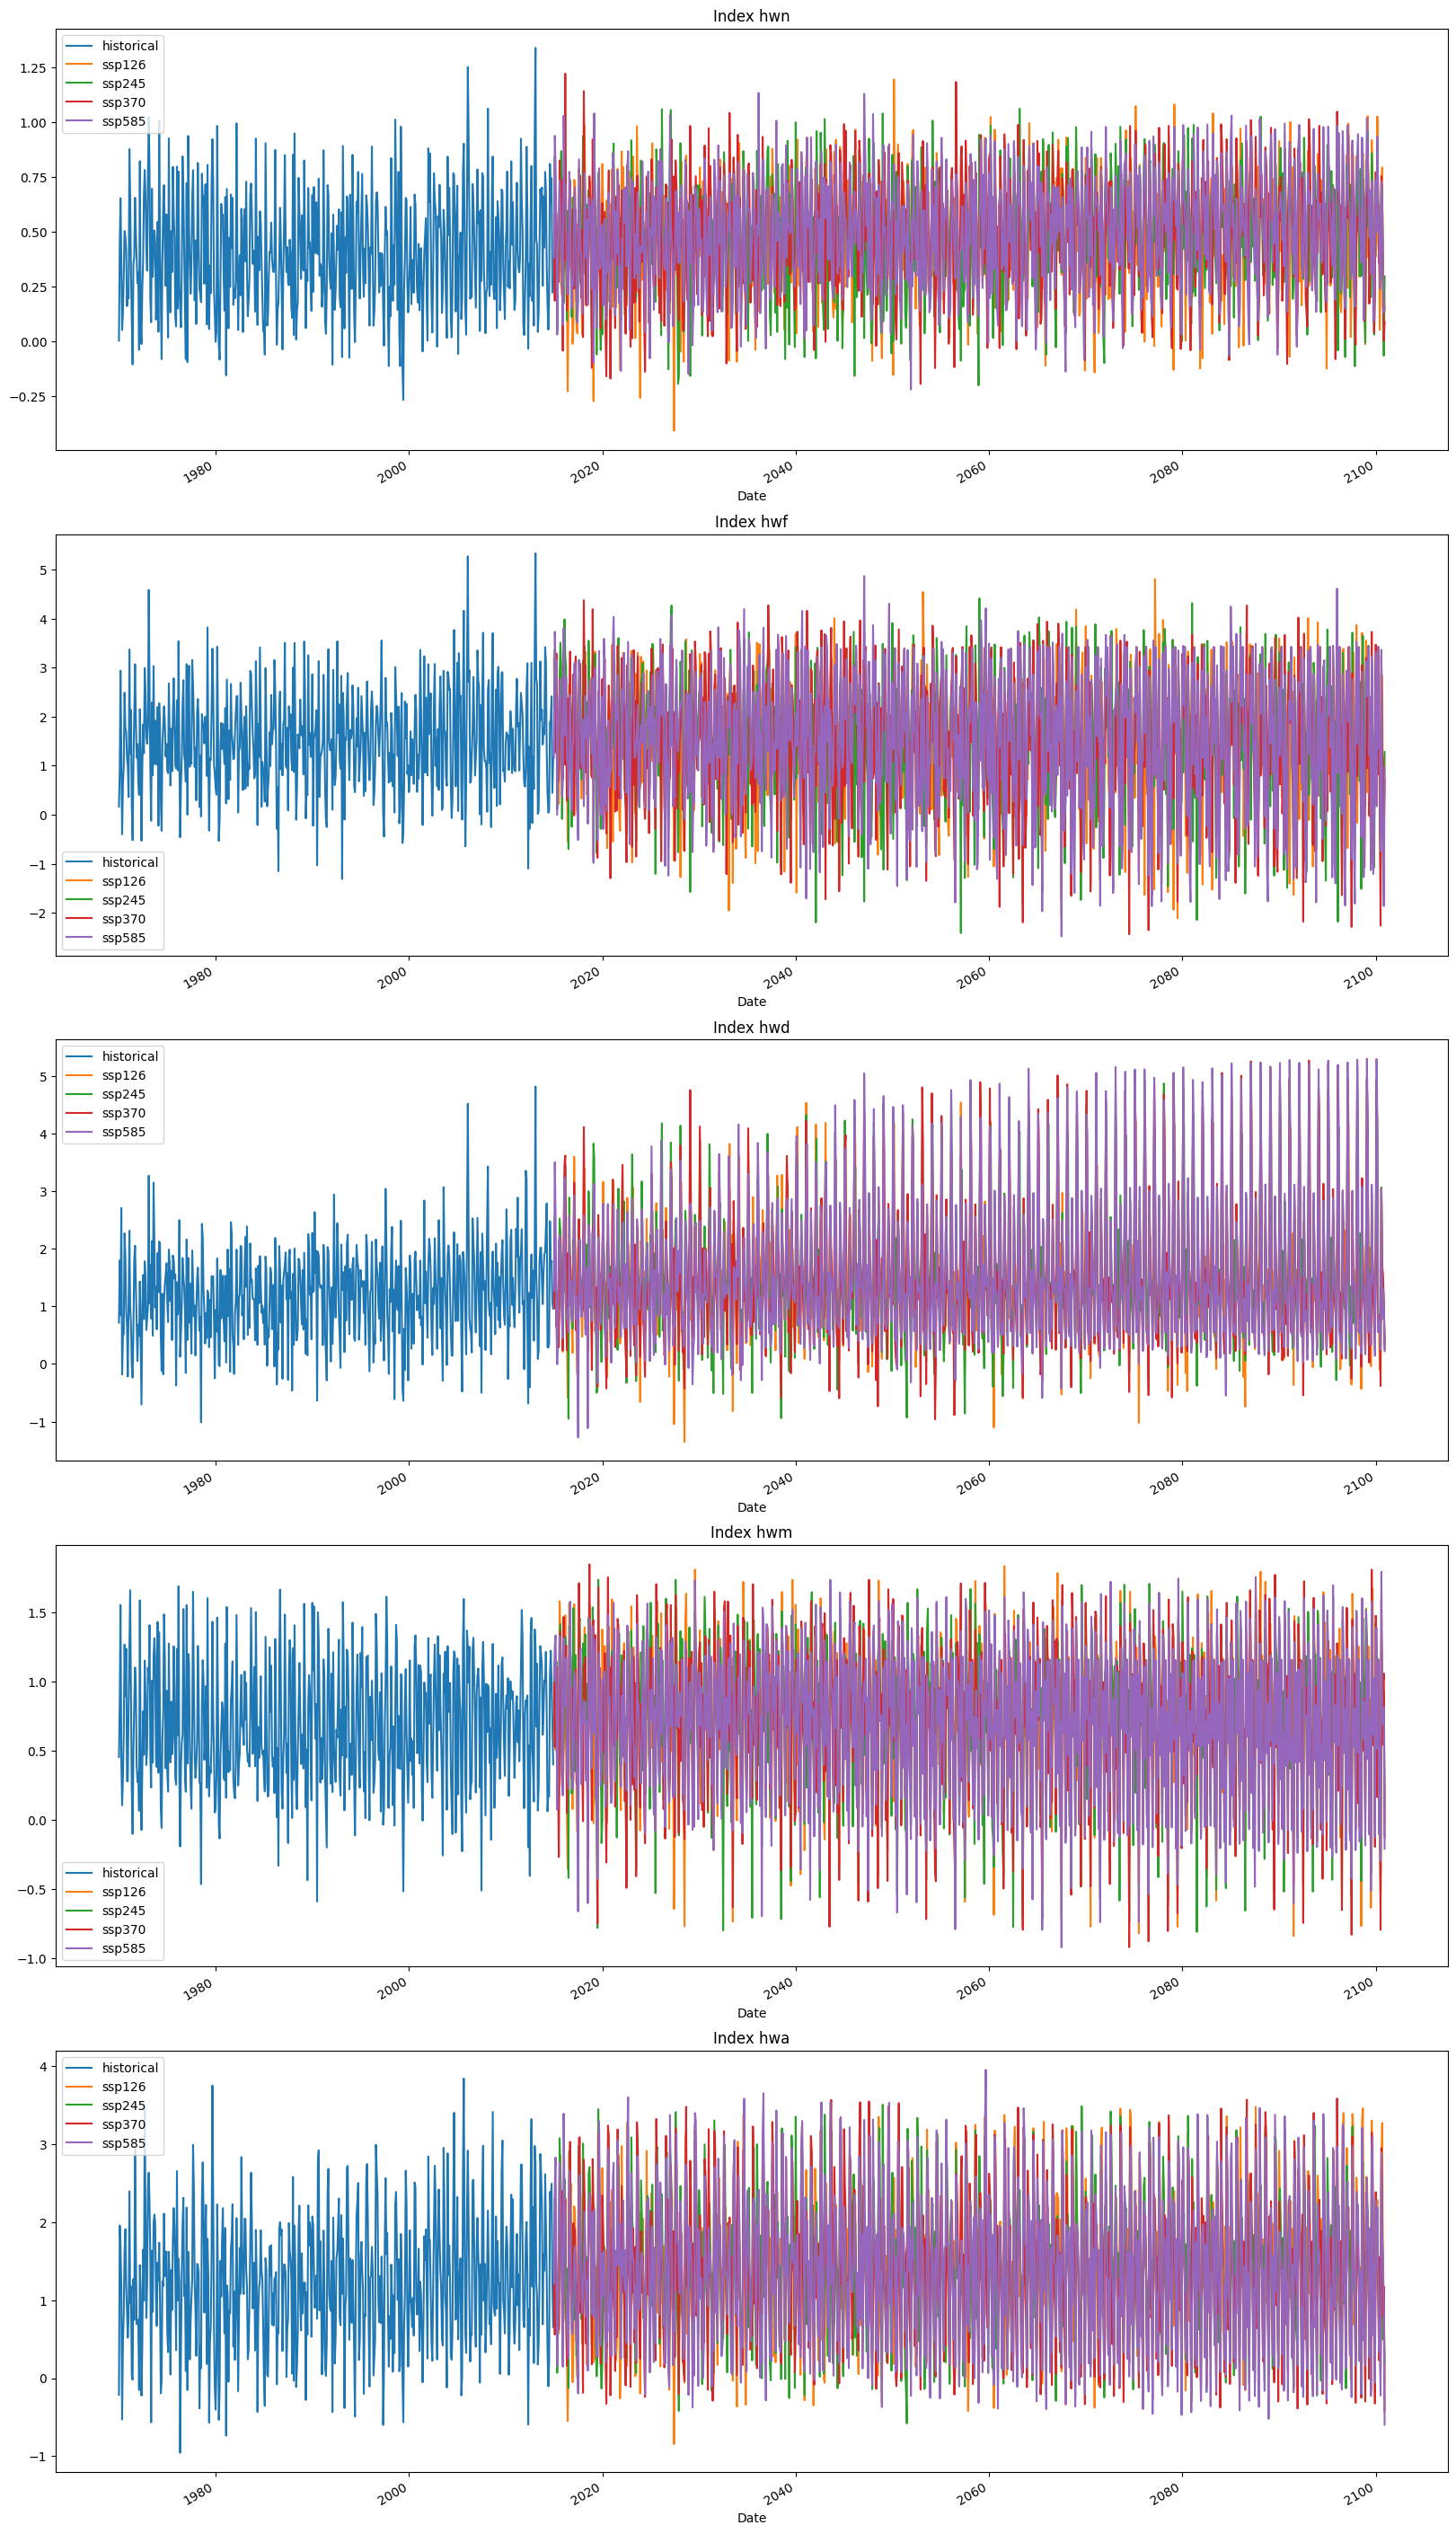

In [48]:
model = "EC-Earth3"
scenarios_prediction = models_scenario_predicted[model]
fig, axs = plt.subplots(5, figsize=(20, 40))
for i, index in enumerate(indices_of_interest):
    for scenario, df in scenarios_prediction.items():
        df.plot(y=index, ax=axs[i], label=scenario)
    axs[i].set_title(f"Index {index}")

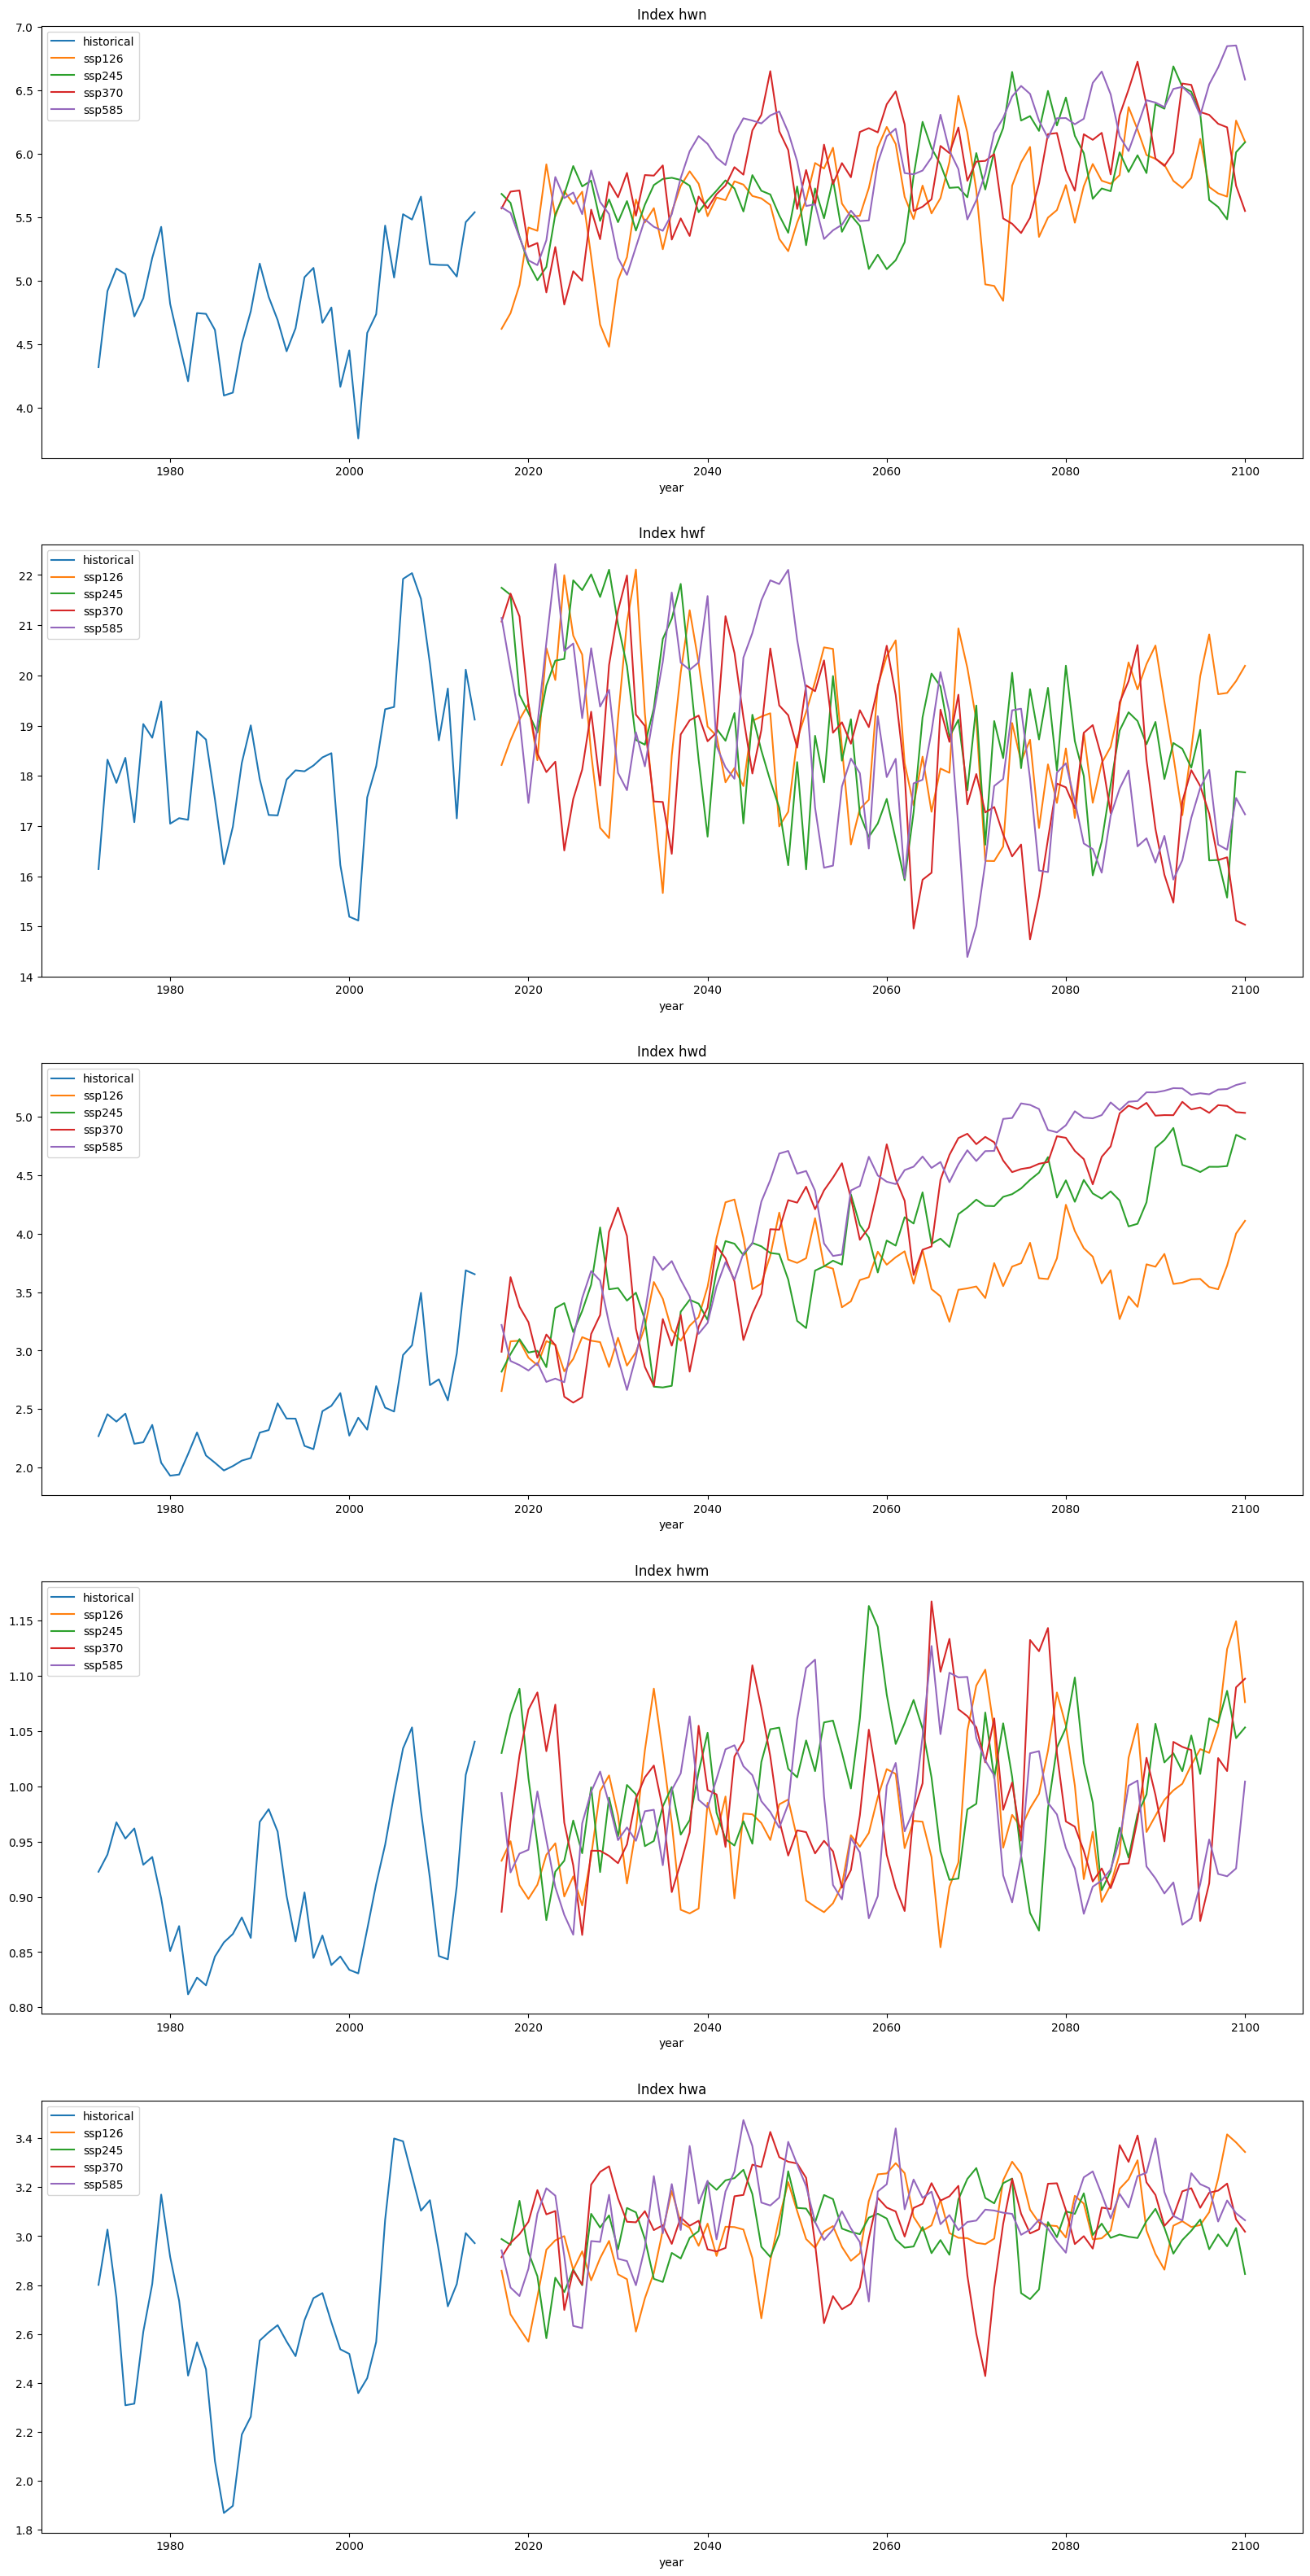

In [52]:
model = "EC-Earth3"
scenarios_prediction = models_predicted_yearly[model]
fig, axs = plt.subplots(5, figsize=(20, 40))
for i, index in enumerate(indices_of_interest):
    for scenario, df in scenarios_prediction.items():
        df.rolling(3).mean().plot(y=index, ax=axs[i], label=scenario)
    axs[i].set_title(f"Index {index}")

### Prediction of ensemble mean model

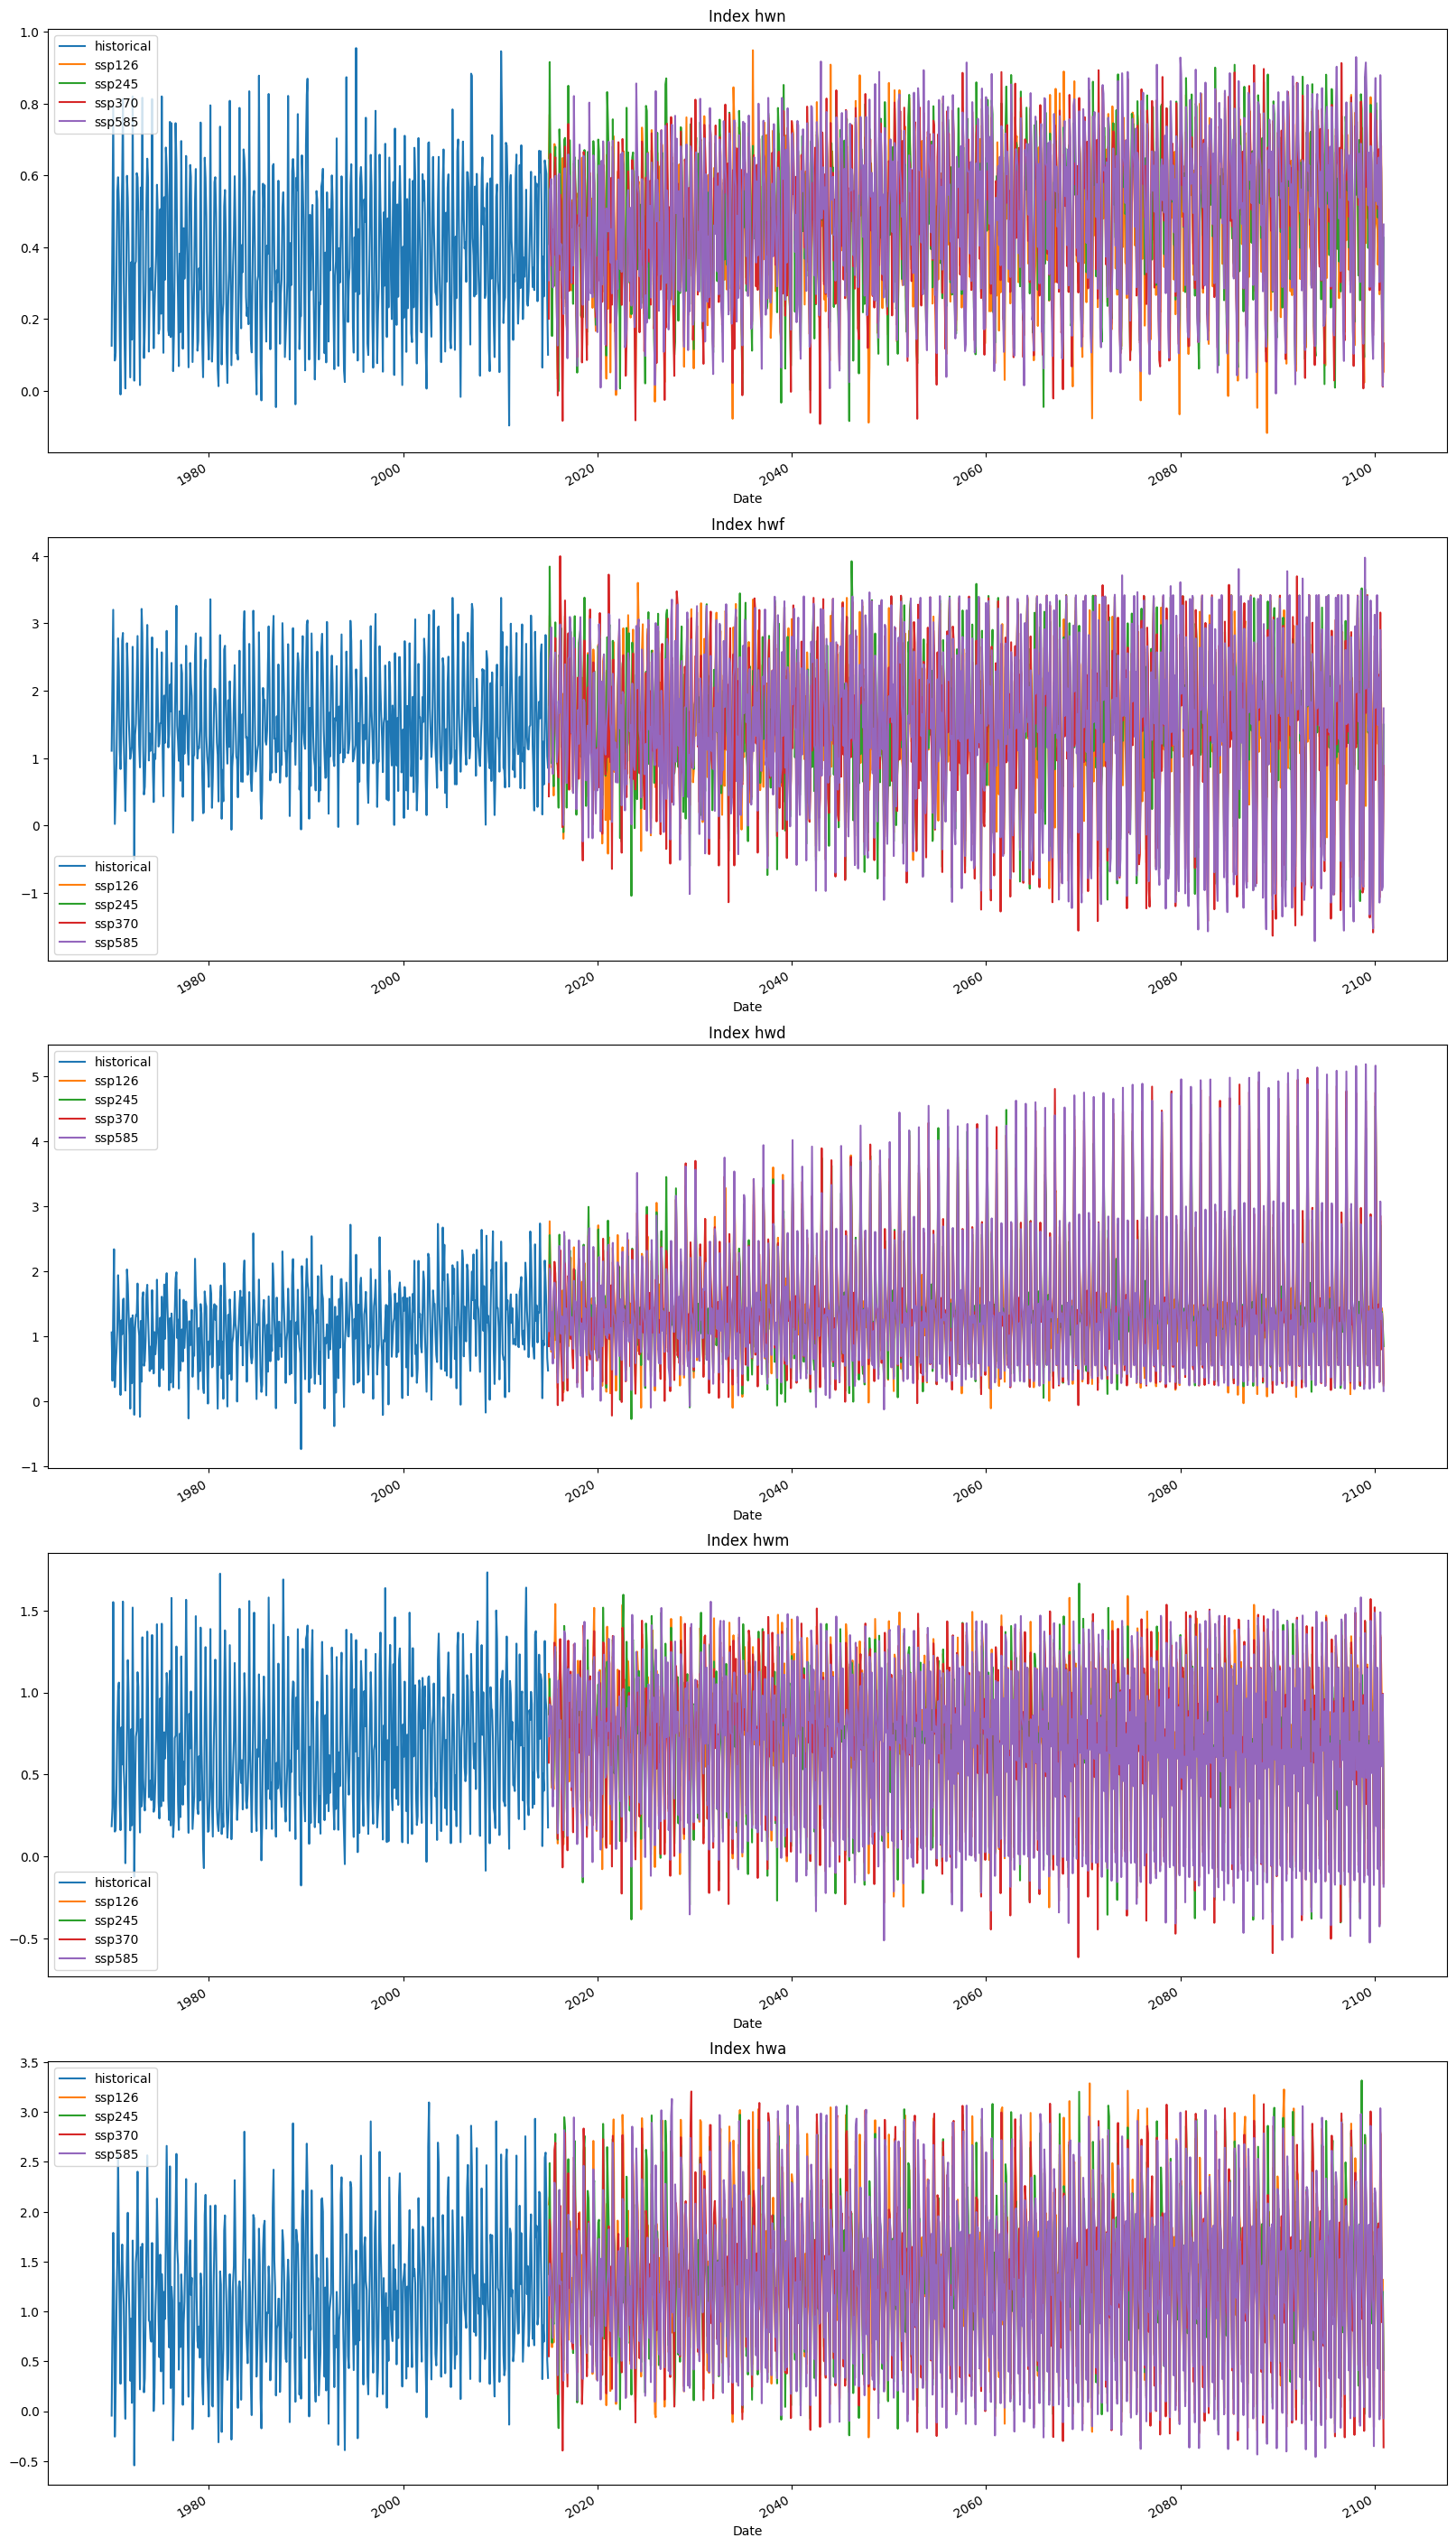

In [57]:
model = "ensemble_mean"
scenarios_prediction = models_scenario_predicted[model]
fig, axs = plt.subplots(5, figsize=(20, 40))
for i, index in enumerate(indices_of_interest):
    for scenario, df in scenarios_prediction.items():
        df.plot(y=index, ax=axs[i], label=scenario)
    axs[i].set_title(f"Index {index}")

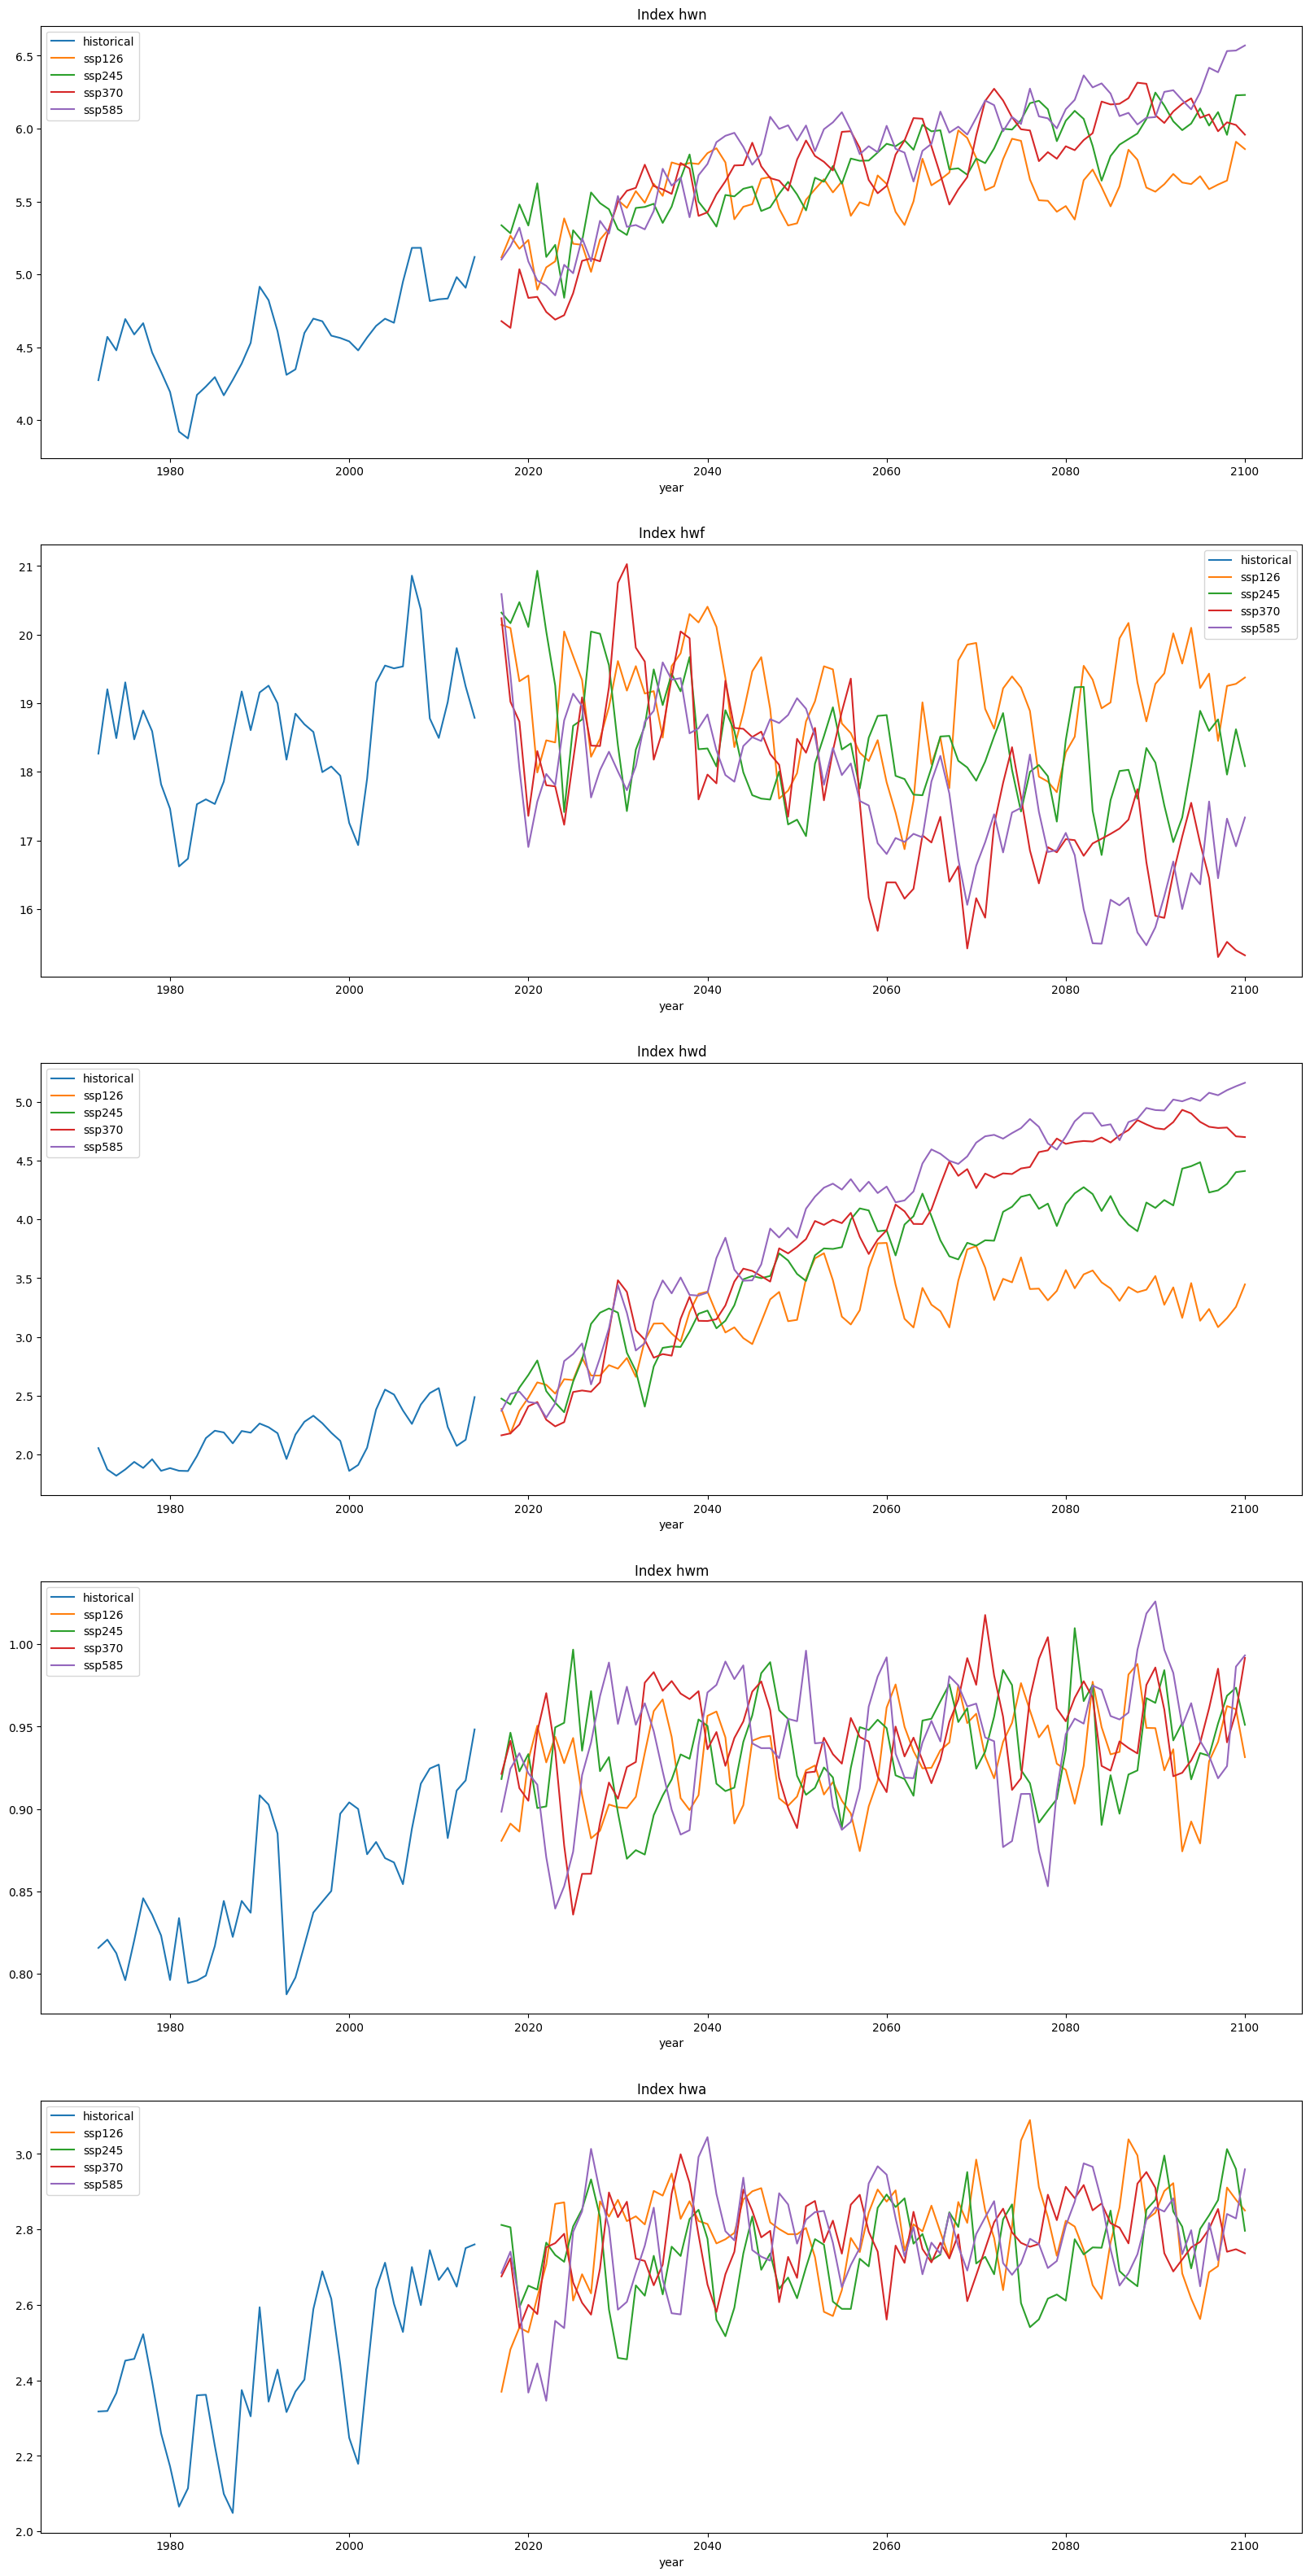

In [ ]:
model = "ensemble_mean"
scenarios_prediction = models_predicted_yearly[model]
fig, axs = plt.subplots(5, figsize=(20, 40))
for i, index in enumerate(indices_of_interest):
    for scenario, df in scenarios_prediction.items():
        df.rolling(3).mean().plot(y=index, ax=axs[i], label=scenario)
    axs[i].set_title(f"Index {index}")

### Mean of predicted Models

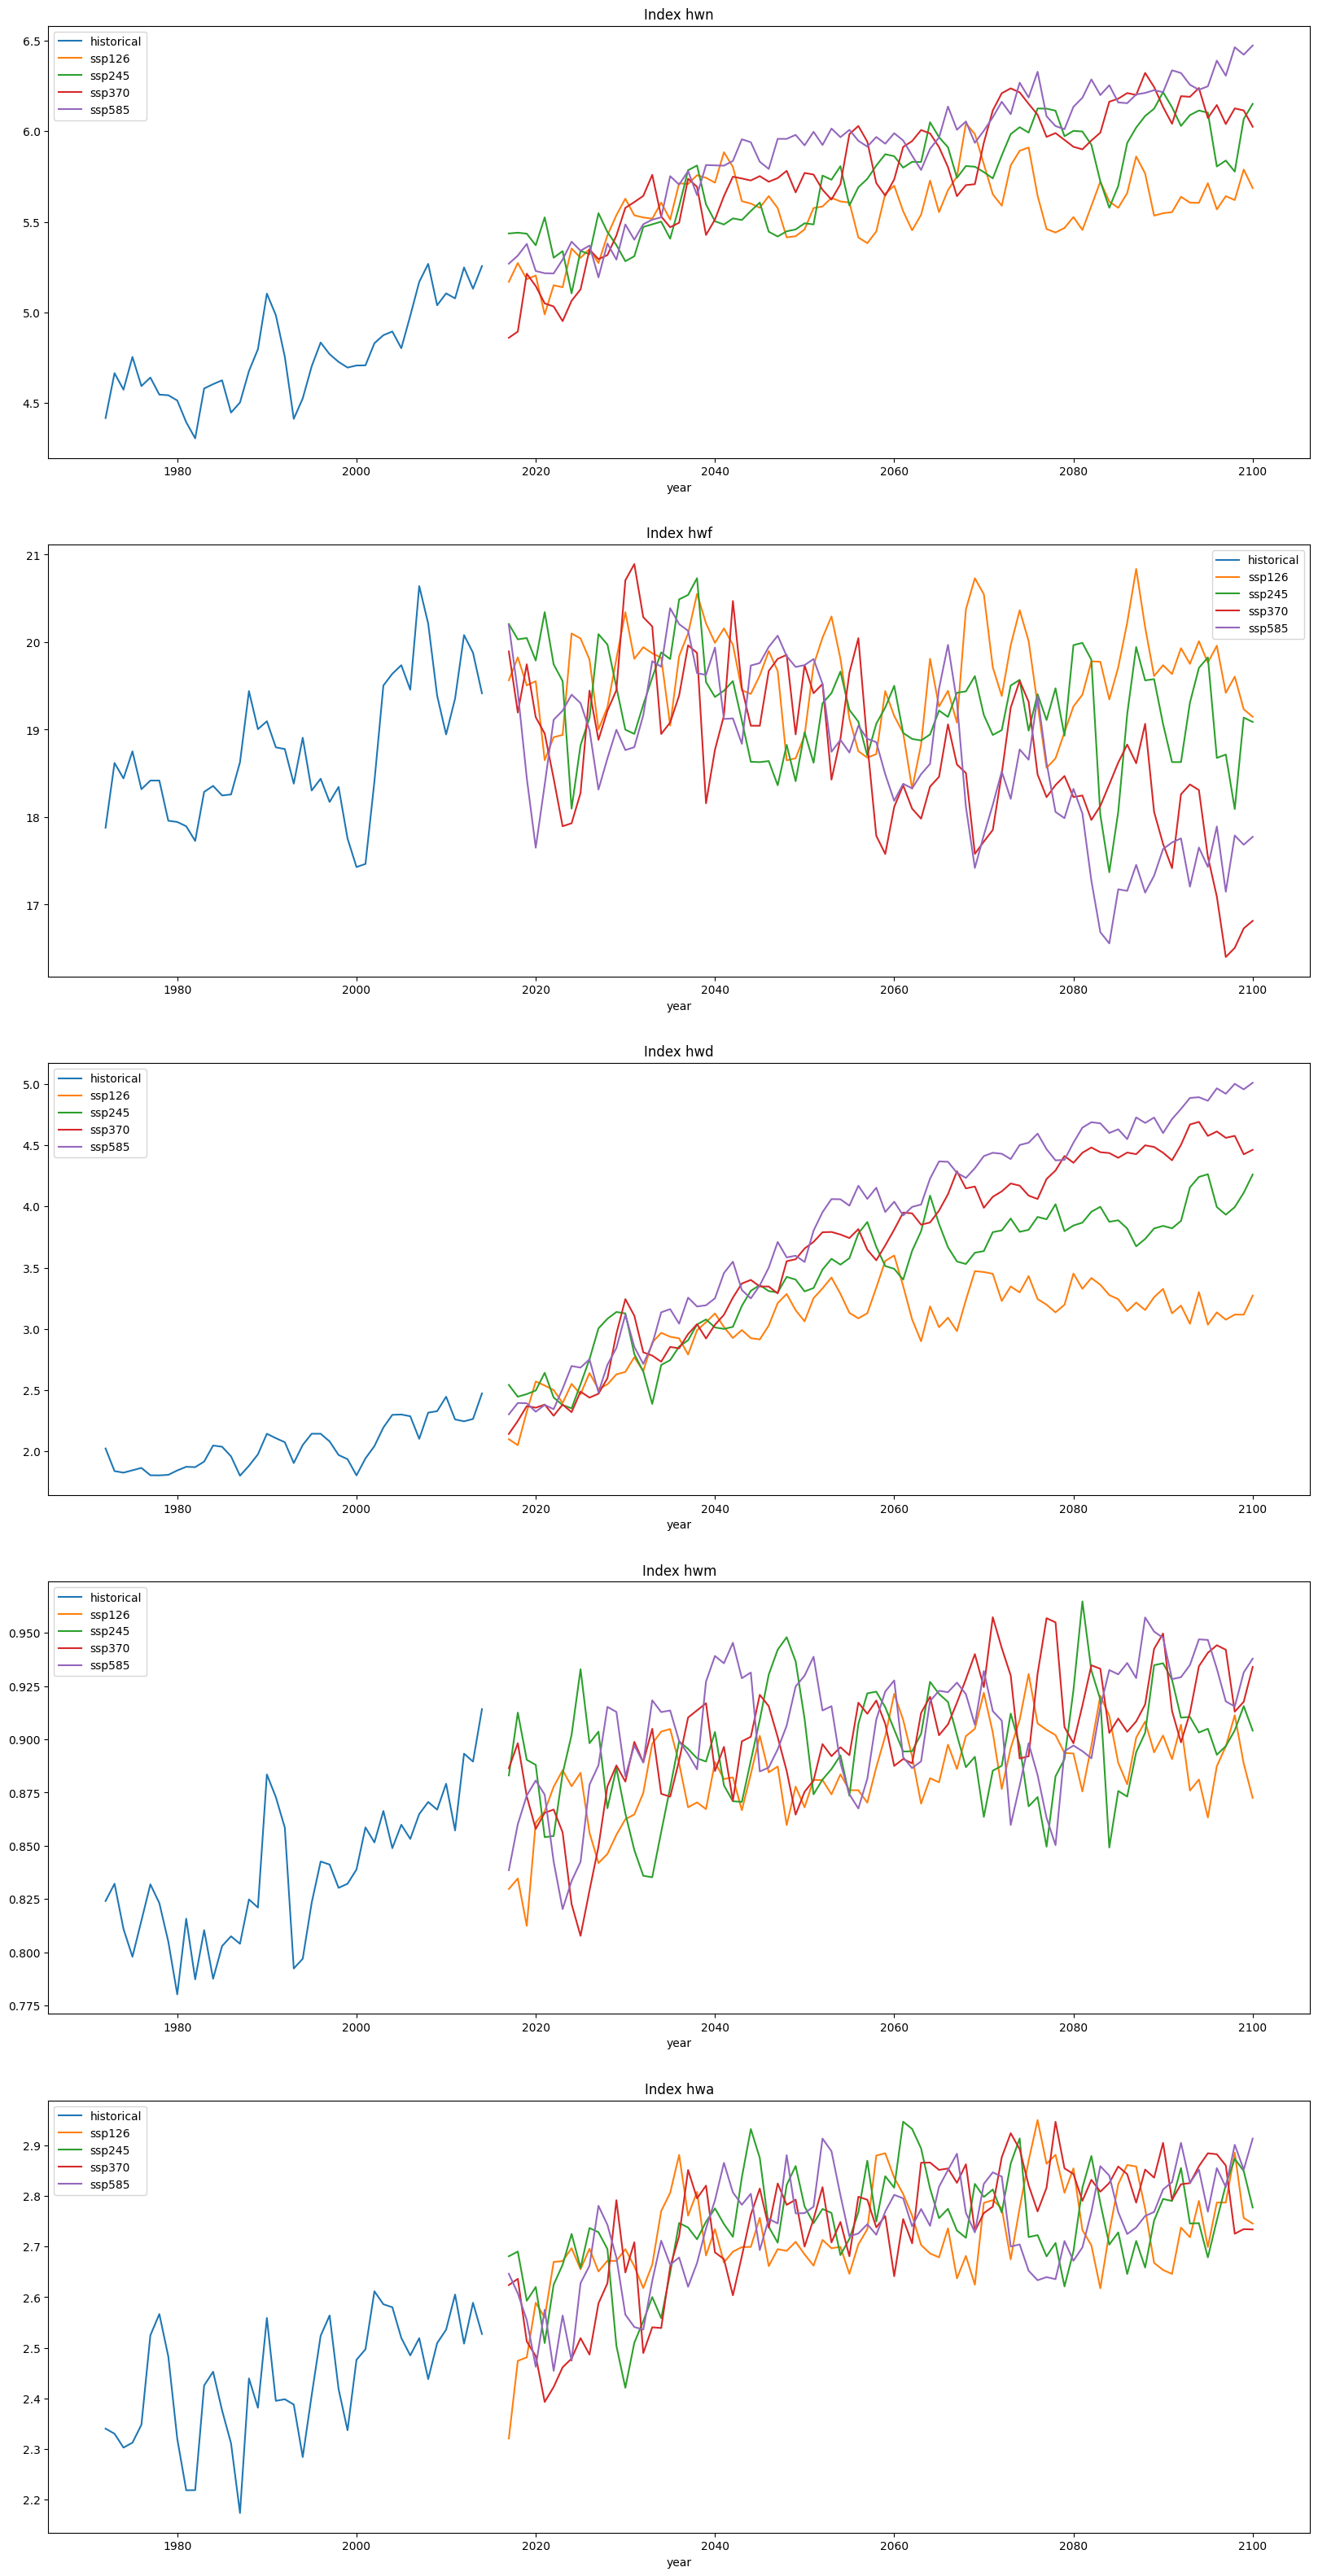

In [ ]:
model = "mean"
scenarios_prediction = models_predicted_yearly[model]
fig, axs = plt.subplots(5, figsize=(20, 40))
for i, index in enumerate(indices_of_interest):
    for scenario, df in scenarios_prediction.items():
        df.rolling(3).mean().plot(y=index, ax=axs[i], label=scenario)
    axs[i].set_title(f"Index {index}")

## Notes

- Missing to include datasets detection (ERA5 for historical + CMIP6 grid detection), this to compare as baseline against our models.

- For now, appears that hwn and hwd are the indices that better adjust to the intuition of the difference of the scenarios. We see only in these indices that the pessimistic scenarios actually give higher indices than the optimistic scenarios. For our luck, hwn is a frequency index and hwd an intensity index. Also we can see in hwa that there is an increasing trend, but it is not very different across each scenario. Again, here is why it is necessary to include the baseline of grid detection, to see if that detection visualize the difference between scenarios aswell.

- Include new heatwaves indices that have logical relationship with each other. So we can check mathematical consistency between them after prediction.
